[Reference Medium](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

In [1]:
import gym
import numpy as np

In [10]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make("FrozenLake-v0")

Docs: https://gym.openai.com/docs/#environments  

---
Each step returns s, r, d, info(for diagnostics)  
s: state/observation  
r: reward  
d: done (bool)  
info: diagnostics  

[Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation)

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state.

In [3]:
print(env.observation_space.n)
print(env.action_space.n)

16
4


In [4]:
# returns array with dimension 1, 4
np.random.randn(1, 4)

array([[0.10419204, 0.55687522, 0.62178451, 0.60473969]])

## Manual Loop version of Frozen Lake

In [6]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95 #discount factor?
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0 #reward
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        
        #Choose an action by greedily (with noise) picking from Q table
        #get maximum of the 4 choices in the current state (cell)
        a = np.argmax(
            # start with calculated probs
            Q[s,:] + 
            # add noise terms
            np.random.randn(
                        1,env.action_space.n)*(1./(i+1)
                                                        )
            )
        
        #From decided action "a", Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        
        #Update Q-Table, target action with new knowledge
        Q[s,a] = ( Q[s,a] # target action cell value
                  + 
                  lr*(
                      r # reward
                      + 
                      y*np.max(Q[s1,:]) # maximum possible reward by experience
                      - 
                      Q[s,a] # 
                      )
                 )
        
        rAll += r # accumlate rewards
        s = s1 # set new state
        
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

In [7]:
# Score is average of all scores acquired in the episodes
print("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 0.6265


In [8]:
print("Final Q-Table Values")
print(Q)

Final Q-Table Values
[[3.01850487e-01 1.14801620e-02 8.60786288e-03 1.07590544e-02]
 [5.78600177e-04 1.03397346e-03 6.51664397e-04 1.79256551e-01]
 [1.03813262e-01 2.59368352e-03 1.60176335e-03 2.47615000e-03]
 [0.00000000e+00 4.30812962e-04 1.30066865e-04 2.38846955e-03]
 [4.60266389e-01 4.95965884e-03 5.01548904e-05 4.66062455e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.30524128e-04 2.16568821e-04 3.68967994e-02 5.15935379e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.95911513e-05 7.94281012e-03 4.37605032e-01]
 [0.00000000e+00 6.41662987e-01 0.00000000e+00 0.00000000e+00]
 [2.24729353e-01 0.00000000e+00 0.00000000e+00 1.67433347e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.62584518e-01 0.00000000e+00]
 [0.00000000e+00 9.90161026e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.

## TF version of Frozen Lake

In [14]:
tf.__version__

'1.14.0'

In [16]:
tf.reset_default_graph()

In [17]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01)) #max value is 0.01?
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1) #get highest number in each row

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [18]:
# training the network itself
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],
                              feed_dict={inputs1:np.identity(16)[s:s+1]}
                             )
            
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
                
                
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(
                Qout,
                feed_dict={inputs1:np.identity(16)[s1:s1+1]}
                )
            
            
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            
            
            #Train our network using target and predicted Q values
            _,W1 = sess.run(
                [updateModel,W],
                feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.402%


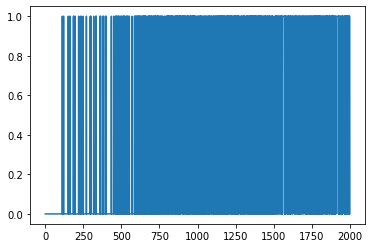

In [19]:
plt.plot(rList)

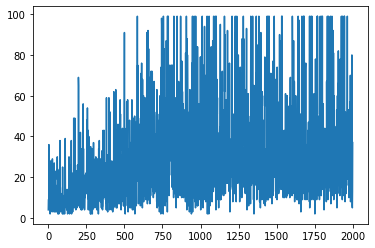

In [20]:
plt.plot(jList)